In [1]:
import json 
import pandas as pd 
import os

# calculate and save median and IQR for all runs 

files = os.listdir('/mnt/home/f0106093/Projects/multiomics-embedding/wandb/')
runs = [f for f in files if 'run' in f]
# runs with embedding average val F1 >= 0.80
top_models = ['8lofhbbf', 'dgst6c87', 'wcksnlsg', '7o4yga2v', 'q2gzu1o3']

time_val = []
time_test = []
diet_val = []
diet_test = []
labels = []

# if run is complete load data 
for run in runs:
    root = f'/mnt/home/f0106093/Projects/multiomics-embedding/wandb/{run}/files'
    fp = f'{root}/wandb-summary.json'
    if not os.path.exists(fp):
        continue

    with open(fp, 'r') as f:
        data = json.load(f)

    if len(data) < 241:
        continue
    

    # get validation data 
    time = pd.DataFrame(index=range(10), columns=range(1,6))
    diet = pd.DataFrame(index=range(10), columns=range(1,6))

    for i in range(1,6):
        for j in range(10):
            time.loc[j,i] = data[f'time_model_{i}_val_{j}_f1']
            diet.loc[j,i] = data[f'diet_model_{i}_val_{j}_f1']

    # calculate validation median, IQR and variance
    time_median = time.median()
    time_iqr = time.quantile(0.75) - time.quantile(0.25)
    time_var = time.var()

    diet_median = diet.median()
    diet_iqr = diet.quantile(0.75) - diet.quantile(0.25)
    diet_var = diet.var()

    val_variance = pd.DataFrame({'time_median' : time_median, 'time_IQR' : time_iqr, 'time_variance': time_var, 
                            'diet_median' : diet_median, 'diet_IQR' : diet_iqr, 'diet_variance': diet_var})

    time_val_median = val_variance['time_median'].median()
    time_val_iqr = (val_variance['time_median'].quantile(0.75) - val_variance['time_median'].quantile(0.25))
    time_val_var = val_variance['time_median'].var()

    diet_val_median = val_variance['diet_median'].median()
    diet_val_iqr = (val_variance['diet_median'].quantile(0.75) - val_variance['diet_median'].quantile(0.25))
    diet_val_var = val_variance['diet_median'].var()

    # get test data
    time_t = pd.Series([data[f'time_model_{i}_test_f1'] for i in range(1,6)])
    diet_t = pd.Series([data[f'diet_model_{i}_test_f1'] for i in range(1,6)])

    # calculate test median, IQR and variance
    time_test_median = time_t.median()
    time_test_iqr = time_t.quantile(0.75) - time_t.quantile(0.25)
    time_test_var = time_t.var()

    diet_test_median = diet_t.median()
    diet_test_iqr = diet_t.quantile(0.75) - diet_t.quantile(0.25)
    diet_test_var = diet_t.var()

    variance = pd.DataFrame({
        'time': [time_val_median, time_val_iqr, time_val_var, time_test_median, time_test_iqr, time_test_var],
        'diet': [diet_val_median, diet_val_iqr, diet_val_var, diet_test_median, diet_test_iqr, diet_test_var]
    }, index=['val_median', 'val_IQR', 'val_variance', 'test_median', 'test_IQR', 'test_variance'])

    #val_variance.to_csv(f'{root}/validation_variance.tsv', sep='\t')
    #variance.to_csv(f'{root}/variance.tsv', sep='\t')

    # for plotting later in script 
    time_val.append((time_val_median, time_val_iqr, time_val_var))
    time_test.append((time_test_median, time_test_iqr, time_test_var))
    diet_val.append((diet_val_median, diet_val_iqr, diet_val_var))
    diet_test.append((diet_test_median, diet_test_iqr, diet_test_var))
    labels.append(run)

# for plotting later in script 
time_val = pd.DataFrame(time_val, columns=['median', 'IQR', 'variance'], index=labels)
time_test = pd.DataFrame(time_test, columns=['median', 'IQR', 'variance'], index=labels)
diet_val = pd.DataFrame(diet_val, columns=['median', 'IQR', 'variance'], index=labels)
diet_test = pd.DataFrame(diet_test, columns=['median', 'IQR', 'variance'], index=labels)

    

In [2]:
import matplotlib.pyplot as plt

def get_color(index, ids):
    for id in ids:
        if id in index:
            return 'orange'
    return 'blue'

def get_labels(index, ids):
    for id in ids:
        if id in index:
            return id
    return None

def plot_scatter(ax, x, y, colors, labels, ymax=None):
    # Plot blue points first
    blue_mask = [color == 'blue' for color in colors]
    ax.scatter(x[blue_mask], y[blue_mask], c='blue', alpha=0.5)
    # Plot orange points on top
    orange_mask = [color == 'orange' for color in colors]
    ax.scatter(x[orange_mask], y[orange_mask], c='orange')
    # Add labels
    for i, label in enumerate(labels):
        if label:  # Only add label if it's not an empty string
            ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
    if ymax is not None:
        # Set axis limits
        ax.set_xlim(0.2, 1)
        ax.set_ylim(0, ymax)

def make_variance_plot(time_val, time_test, diet_val, diet_test, ids, y_val):
    colors = [get_color(idx, ids) for idx in time_val.index]
    
    point_labels = [get_labels(idx, ids) for idx in time_val.index]

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    plot_scatter(axs[0, 0], time_val['median'], time_val[y_val], colors, point_labels)
    axs[0, 0].set_title('Time Validation')
    axs[0, 0].set_xlabel('Median')
    axs[0, 0].set_ylabel(y_val)

    plot_scatter(axs[0, 1], time_test['median'], time_test[y_val], colors, point_labels)
    axs[0, 1].set_title('Time Test')
    axs[0, 1].set_xlabel('Median')
    axs[0, 1].set_ylabel(y_val)

    plot_scatter(axs[1, 0], diet_val['median'], diet_val[y_val], colors, point_labels)
    axs[1, 0].set_title('Diet Validation')
    axs[1, 0].set_xlabel('Median')
    axs[1, 0].set_ylabel(y_val)

    plot_scatter(axs[1, 1], diet_test['median'], diet_test[y_val], colors, point_labels)
    axs[1, 1].set_title('Diet Test')
    axs[1, 1].set_xlabel('Median')
    axs[1, 1].set_ylabel(y_val)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_3051436/4127931590.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
/tmp/ipykernel_3051436/4127931590.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
/tmp/ipykernel_3051436/4127931590.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize

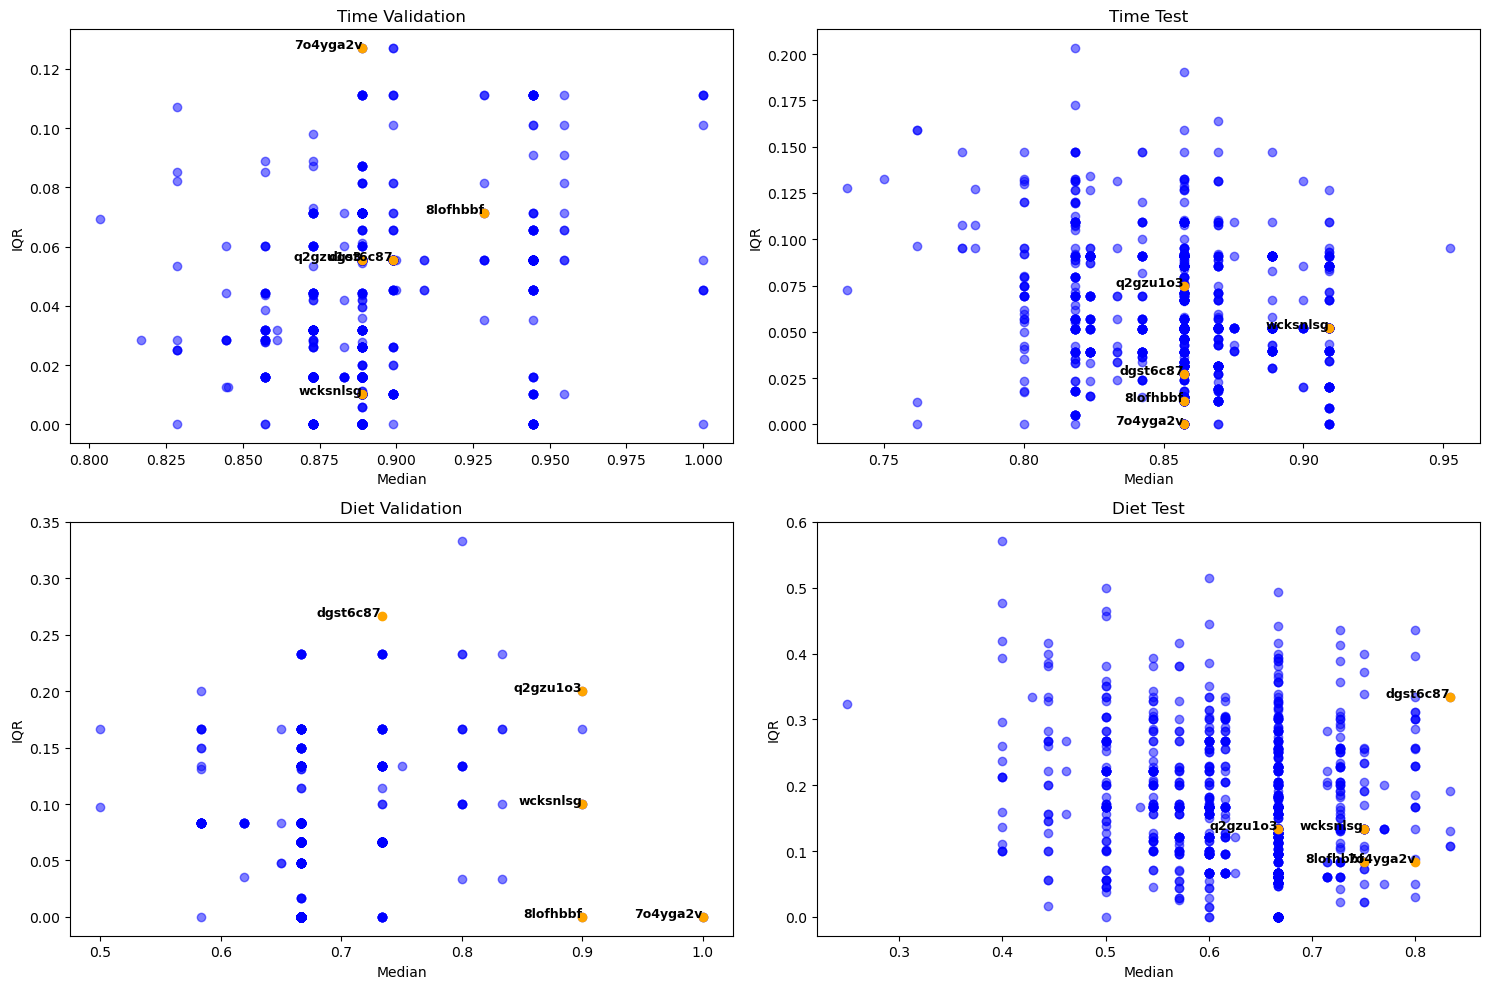

In [3]:
make_variance_plot(time_val, time_test, diet_val, diet_test, top_models, 'IQR')

/tmp/ipykernel_3051436/4127931590.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
/tmp/ipykernel_3051436/4127931590.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
/tmp/ipykernel_3051436/4127931590.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize

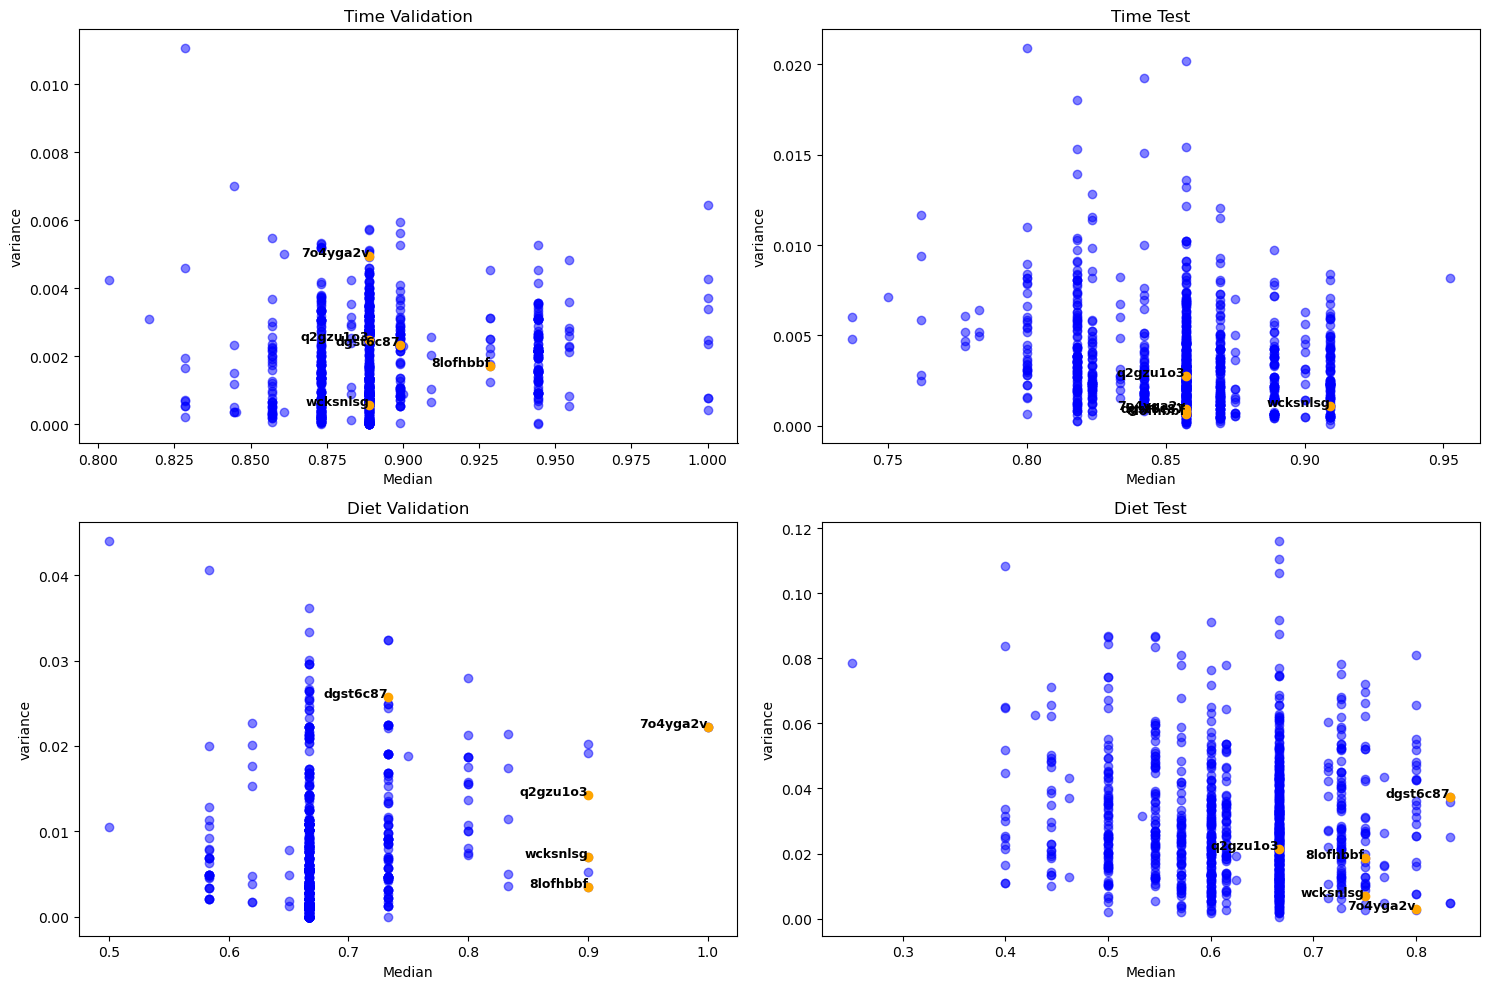

In [4]:
make_variance_plot(time_val, time_test, diet_val, diet_test, top_models, 'variance')

In [5]:
import os
import pandas as pd

files = os.listdir('/mnt/home/f0106093/Projects/multiomics-embedding/wandb/')
runs = [f for f in files if 'run' in f and 'latest' not in f]
top_runs = []
for run in runs:
    root = f'/mnt/home/f0106093/Projects/multiomics-embedding/wandb/{run}/files'
    fp = f'{root}/variance.tsv'
    if not os.path.exists(fp):
        continue
    var = pd.read_csv(fp, sep='\t', index_col=0)
    if var.loc['val_median', 'diet'] >= 0.9:
        print(run)
    if var.loc['val_median', 'diet'] >= 0.88 and var.loc['val_IQR', 'diet'] <= 0.25:
        top_runs.append(run)
run_ids = [run.split('-')[-1] for run in top_runs]
print(run_ids)

run-20241023_140013-8f5hvjwq
run-20241020_212554-wcksnlsg
run-20241022_050306-ai9n4jxs
run-20241020_235607-7o4yga2v
run-20241022_033012-21tdsqsa
run-20241023_162738-r5e0976o
run-20241011_174915-q2gzu1o3
run-20241023_151329-qb4y98x0
run-20241022_090641-8lofhbbf
run-20241024_145912-ukchmaw8
['8f5hvjwq', 'wcksnlsg', 'ai9n4jxs', '7o4yga2v', '21tdsqsa', 'r5e0976o', 'q2gzu1o3', 'qb4y98x0', '8lofhbbf', 'ukchmaw8']


equivalent models: 

p = 0.5, q = 1.895944090041435, g = 1 : 7o4yga2v, ukchmaw8 

p = 19, q = 9.122152261131532, g = 1 : wcksnlsg, r5e0976o, 6d4lhdv1

p = 5.5, q = 9.010757520712524, g = 1 : dgst6c87, qb4y98x0

p = 7.305688086564288, q = 7.517332462471247, g = 2 : 8lofhbbf, 8f5hvjwq

p = 19, q = 8.483911078685804, g = 2 : q2gzu1o3

p = 1.0795506927238254, q = 8.383911078685804, g = 1 : 21tdsqsa

p = 0.8055551041134607, q = 0.1, g = 1 : ai9n4jxs, 

/tmp/ipykernel_3051436/4127931590.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
/tmp/ipykernel_3051436/4127931590.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize=9, ha='right', fontweight='bold')
/tmp/ipykernel_3051436/4127931590.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], label, fontsize

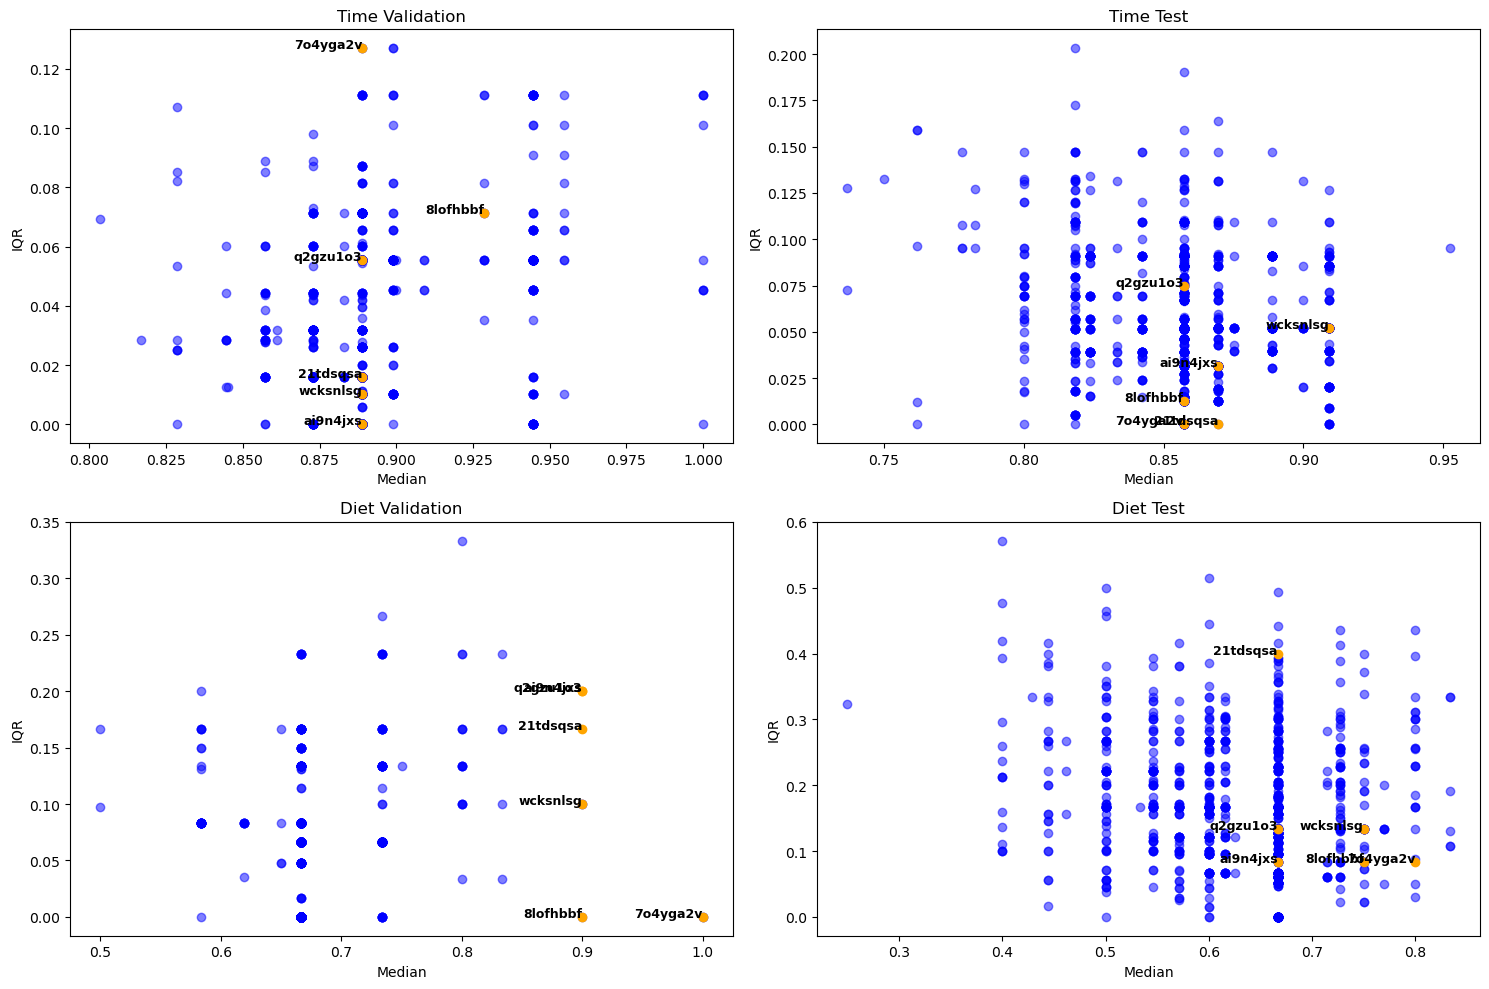

In [6]:
top_run_ids = ['7o4yga2v', 'wcksnlsg', '8lofhbbf', 'q2gzu1o3', '21tdsqsa', 'ai9n4jxs']
make_variance_plot(time_val, time_test, diet_val, diet_test, top_run_ids, 'IQR')


In [7]:
for run in files:
    if not any(top_run_id in run for top_run_id in top_run_ids):
        continue
    root = f'/mnt/home/f0106093/Projects/multiomics-embedding/wandb/{run}/files'
    summary_fp = f'{root}/wandb-summary.json'
    var_fp =  f'{root}/variance.tsv'

    with open(summary_fp, 'r') as f:
        data = json.load(f)

    emb = data['emb_score']
    diet = data['diet_avg_val_f1']
    time = data['time_avg_val_f1']
    
    var = pd.read_csv(var_fp, sep='\t', index_col=0)

    print(run.split('-')[-1])
    print(f'embedding score: {emb}')
    print(f'average diet F1: {diet}')
    print(f'average time F1: {time}')
    print('Variance')
    print(var)
    print()
    print()

wcksnlsg
embedding score: 0.8483607503607503
average diet F1: 0.8019999999999999
average time F1: 0.8947215007215007
Variance
                   time      diet
val_median     0.888889  0.900000
val_IQR        0.010101  0.100000
val_variance   0.000582  0.007000
test_median    0.909091  0.750000
test_IQR       0.051948  0.133333
test_variance  0.001089  0.006963


ai9n4jxs
embedding score: 0.8067857142857142
average diet F1: 0.7473333333333333
average time F1: 0.8662380952380951
Variance
                   time      diet
val_median     0.888889  0.900000
val_IQR        0.000000  0.200000
val_variance   0.003867  0.020222
test_median    0.869565  0.666667
test_IQR       0.031746  0.083333
test_variance  0.011521  0.007058


7o4yga2v
embedding score: 0.8474321789321789
average diet F1: 0.8006666666666666
average time F1: 0.8941976911976912
Variance
                   time      diet
val_median     0.888889  1.000000
val_IQR        0.126984  0.000000
val_variance   0.004963  0.022222
test_m